In [51]:
# Loading basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pydicom
import SimpleITK as sitk
import random
import time
import joblib

In [52]:
# Loading modeling libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc, roc_auc_score, classification_report, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display
import tensorflow as tf
from tensorflow import keras

In [53]:
# Loading XGB libraries
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance

In [54]:
import shap
shap.initjs()

In [55]:
def plot_confusion_matrix(conf_mat,
                          hide_spines=False,
                          hide_ticks=False,
                          figsize=None,
                          cmap=None,
                          colorbar=False,
                          show_absolute=True,
                          show_normed=False,
                          class_names=None):

    if not (show_absolute or show_normed):
        raise AssertionError('Both show_absolute and show_normed are False')
    if class_names is not None and len(class_names) != len(conf_mat):
        raise AssertionError('len(class_names) should be equal to number of'
                             'classes in the dataset')

    total_samples = conf_mat.sum(axis=0)[:, np.newaxis]
    normed_conf_mat = conf_mat.astype('float') / total_samples.T

    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(False)
    if cmap is None:
        cmap = plt.cm.Blues

    if figsize is None:
        figsize = (len(conf_mat)*1.25, len(conf_mat)*1.25)

    if show_normed:
        matshow = ax.matshow(normed_conf_mat, cmap=cmap)
    else:
        matshow = ax.matshow(conf_mat, cmap=cmap)

    if colorbar:
        fig.colorbar(matshow)

    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            cell_text = ""
            if show_absolute:
                cell_text += format(conf_mat[i, j], 'd')
                if show_normed:
                    cell_text += "\n" + '('
                    cell_text += format(normed_conf_mat[i, j], '.2f') + ')'
            else:
                cell_text += format(normed_conf_mat[i, j], '.2f')
            if show_normed:
                ax.text(x=j,
                        y=i,
                        s=cell_text,
                        va='center',
                        ha='center',
                        color="white" if normed_conf_mat[i, j] > 0.5
                        else "black")
            else:
                ax.text(x=j,
                        y=i,
                        s=cell_text,
                        va='center',
                        ha='center',
                        color="white" if conf_mat[i, j] > np.max(conf_mat)/2
                        else "black")
    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45)
        plt.yticks(tick_marks, class_names)

    if hide_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if hide_ticks:
        ax.axes.get_yaxis().set_ticks([])
        ax.axes.get_xaxis().set_ticks([])

    plt.xlabel('predicted label')
    plt.ylabel('true label')
    return fig, ax


In [56]:
df = pd.read_csv('../abt/ABT2.csv')
#df

In [57]:
df.head()

,PID_STUDY,PID,ID,StudyInstanceUid,PAT_STUDY,case,SEX,BIRTHDAY,PATIENT_AGE,STUDY_DATE,...,C1_C_YN_past3mo,C1_4_YN_past3mo,C1_D_YN_past3mo,C1_2_YN_past3mo,C1_F_YN_past3mo,C1_6_YN_past3mo,C1_8_YN_past3mo,C1_G_YN_past3mo,C1_1_YN_past3mo,C1_9_YN_past3mo
0,psuedoID_0001_S001,psuedoID_0001,1.2.840.4617251246150175204137172199922377412680,1.2.840.52234177712510410248100181209188129412573,psuedoID_00011.2.840.5223417771251041024810018...,1,1,1936-10-05,81,2018-05-08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,psuedoID_0002_S001,psuedoID_0002,1.2.840.115801116189224918693562471361061736619,1.2.840.17321436186174151857619612929141411101...,psuedoID_00021.2.840.1732143618617415185761961...,1,1,1950-03-06,68,2018-07-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,psuedoID_0003_S001,psuedoID_0003,1.2.840.39171128759759431061437311515024288129254,1.2.840.137891474015176123923111219516920646109,psuedoID_00031.2.840.1378914740151761239231112...,1,1,1937-07-12,80,2018-05-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,psuedoID_0004_S001,psuedoID_0004,1.2.840.18132111781482106246251981641121161052...,1.2.840.133140186211161223196179932489043534336,psuedoID_00041.2.840.1331401862111612231961799...,1,1,1945-01-15,73,2018-04-09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,psuedoID_0005_S001,psuedoID_0005,1.2.840.5840132263014111212910632001518425224348,1.2.840.14611381252228199267198167212200105206...,psuedoID_00051.2.840.1461138125222819926719816...,1,1,1941-12-11,77,2018-12-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
df_tmp = pd.read_csv('../abt/CNN_tensor_output_0929.csv')
df_tmp['PATIENT'] = df_tmp.final_key.str.split('_', expand=True)[0]
df_tmp['PATIENT'] = df_tmp.PATIENT.str.split('P',expand=True)[1]
df_tmp['STUDY'] = df_tmp.final_key.str.split('_', expand=True)[1]
df_tmp['STUDY'] = df_tmp.STUDY.str.split('S',expand=True)[1]
df_tmp['KEY_ID'] = 'psuedoID_' + df_tmp.PATIENT + '_S0' + df_tmp.STUDY
df_tmp = df_tmp.loc[(df_tmp.final_key.str.contains('_R02_'))].reset_index(drop=True)

In [59]:
df_final = pd.merge(df, df_tmp, how='left', left_on='PID_STUDY', right_on='KEY_ID' )
df_final

,PID_STUDY,PID,ID,StudyInstanceUid,PAT_STUDY,case,SEX,BIRTHDAY,PATIENT_AGE,STUDY_DATE,...,CNN_dense_tensor_26,CNN_dense_tensor_27,CNN_dense_tensor_28,CNN_dense_tensor_29,CNN_dense_tensor_30,CNN_dense_tensor_31,CNN_dense_tensor_32,PATIENT,STUDY,KEY_ID
0,psuedoID_0001_S001,psuedoID_0001,1.2.840.4617251246150175204137172199922377412680,1.2.840.52234177712510410248100181209188129412573,psuedoID_00011.2.840.5223417771251041024810018...,1,1,1936-10-05,81,2018-05-08,...,0.432039,0.000000,0.000000,0.000000,0.655858,0.000000,0.000000,0001,01,psuedoID_0001_S001
1,psuedoID_0002_S001,psuedoID_0002,1.2.840.115801116189224918693562471361061736619,1.2.840.17321436186174151857619612929141411101...,psuedoID_00021.2.840.1732143618617415185761961...,1,1,1950-03-06,68,2018-07-07,...,0.864770,0.831926,1.476521,1.540499,0.000000,0.624500,1.454029,0002,01,psuedoID_0002_S001
2,psuedoID_0003_S001,psuedoID_0003,1.2.840.39171128759759431061437311515024288129254,1.2.840.137891474015176123923111219516920646109,psuedoID_00031.2.840.1378914740151761239231112...,1,1,1937-07-12,80,2018-05-09,...,0.992405,0.007471,0.000000,1.025858,0.000000,0.000000,0.261767,0003,01,psuedoID_0003_S001
3,psuedoID_0004_S001,psuedoID_0004,1.2.840.18132111781482106246251981641121161052...,1.2.840.133140186211161223196179932489043534336,psuedoID_00041.2.840.1331401862111612231961799...,1,1,1945-01-15,73,2018-04-09,...,0.484740,0.217014,1.019021,1.081106,0.001780,0.469289,0.166552,0004,01,psuedoID_0004_S001
4,psuedoID_0005_S001,psuedoID_0005,1.2.840.5840132263014111212910632001518425224348,1.2.840.14611381252228199267198167212200105206...,psuedoID_00051.2.840.1461138125222819926719816...,1,1,1941-12-11,77,2018-12-31,...,0.702824,0.212757,0.000000,0.441624,0.000000,0.000000,0.000000,0005,01,psuedoID_0005_S001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6621,psuedoID_6483_S001,psuedoID_6483,1.2.840.17985592164423020823612314104814193228225,1.2.840.14718810822016391876137143241162218281...,psuedoID_64831.2.840.1471881082201639187613714...,0,1,1957-11-02,60,2018-04-30,...,0.518340,0.000000,0.000000,0.000000,1.595771,0.000000,0.000000,6483,01,psuedoID_6483_S001
6622,psuedoID_6484_S001,psuedoID_6484,1.2.840.992464428171179717520861144102222269454,1.2.840.148116179344447221230551215120924914392,psuedoID_64841.2.840.1481161793444472212305512...,0,1,1955-05-20,63,2018-06-11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6623,psuedoID_6485_S001,psuedoID_6485,1.2.840.136471251053717241452504778178109161232,1.2.840.70187247202152621816622416615721140190...,psuedoID_64851.2.840.7018724720215262181662241...,0,2,1969-08-22,49,2018-11-01,...,0.000000,0.000000,0.000000,0.000000,1.414949,0.000000,0.000000,6485,01,psuedoID_6485_S001
6624,psuedoID_6486_S001,psuedoID_6486,1.2.840.23323217113156411092026623220140107191064,1.2.840.20517514043751711651141150401752162167...,psuedoID_64861.2.840.2051751404375171165114115...,0,2,1963-12-30,54,2018-03-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
df.shape

(6626, 22073)

In [61]:
list(df_final.columns) 

['PID_STUDY',
 'PID',
 'ID',
 'StudyInstanceUid',
 'PAT_STUDY',
 'case',
 'SEX',
 'BIRTHDAY',
 'PATIENT_AGE',
 'STUDY_DATE',
 'OP_infectious_A_forever',
 'OP_infectious_B_forever',
 'OP_infectious_C_forever',
 'OP_infectious_D_forever',
 'OP_infectious_E_forever',
 'OP_infectious_F_forever',
 'OP_infectious_G_forever',
 'OP_neoplasms_A_forever',
 'OP_neoplasms_B_forever',
 'OP_neoplasms_C_forever',
 'OP_neoplasms_D_forever',
 'OP_neoplasms_E_forever',
 'OP_neoplasms_F_forever',
 'OP_endocrine_A_forever',
 'OP_endocrine_B_forever',
 'OP_endocrine_C_forever',
 'OP_blood_A_forever',
 'OP_blood_B_forever',
 'OP_mental_A_forever',
 'OP_mental_B_forever',
 'OP_mental_C_forever',
 'OP_nervous_A_forever',
 'OP_nervous_B_forever',
 'OP_nervous_C_forever',
 'OP_nervous_D_forever',
 'OP_circulatory_A_forever',
 'OP_circulatory_C_forever',
 'OP_circulatory_D_forever',
 'OP_respiratory_A_forever',
 'OP_respiratory_B_forever',
 'OP_respiratory_C_forever',
 'OP_respiratory_D_forever',
 'OP_digestive_A_forever',
 'OP_digestive_B_forever',
 'OP_digestive_C_forever',
 'OP_digestive_D_forever',
 'OP_genitourinary_A_forever',
 'OP_genitourinary_B_forever',
 'OP_genitourinary_C_forever',
 'OP_genitourinary_D_forever',
 'OP_pregnancy_A_forever',
 'OP_pregnancy_B_forever',
 'OP_pregnancy_C_forever',
 'OP_pregnancy_D_forever',
 'OP_skin_A_forever',
 'OP_skin_B_forever',
 'OP_skin_C_forever',
 'OP_musculoskeletal_A_forever',
 'OP_musculoskeletal_B_forever',
 'OP_musculoskeletal_C_forever',
 'OP_congenita_A_forever',
 'OP_congenita_B_forever',
 'OP_perinatal_A_forever',
 'OP_symptoms_A_forever',
 'OP_symptoms_B_forever',
 'OP_symptoms_C_forever',
 'OP_injury_A_forever',
 'OP_injury_B_forever',
 'OP_injury_C_forever',
 'OP_injury_D_forever',
 'OP_injury_E_forever',
 'OP_injury_F_forever',
 'HP_infectious_A_forever',
 'HP_infectious_B_forever',
 'HP_infectious_C_forever',
 'HP_infectious_D_forever',
 'HP_infectious_E_forever',
 'HP_infectious_F_forever',
 'HP_infectious_G_forever',
 'HP_neoplasms_A_forever',
 'HP_neoplasms_B_forever',
 'HP_neoplasms_C_forever',
 'HP_neoplasms_D_forever',
 'HP_neoplasms_E_forever',
 'HP_neoplasms_F_forever',
 'HP_endocrine_A_forever',
 'HP_endocrine_B_forever',
 'HP_endocrine_C_forever',
 'HP_blood_A_forever',
 'HP_blood_B_forever',
 'HP_mental_A_forever',
 'HP_mental_B_forever',
 'HP_mental_C_forever',
 'HP_nervous_A_forever',
 'HP_nervous_B_forever',
 'HP_nervous_C_forever',
 'HP_nervous_D_forever',
 'HP_circulatory_A_forever',
 'HP_circulatory_C_forever',
 'HP_circulatory_D_forever',
 'HP_respiratory_A_forever',
 'HP_respiratory_B_forever',
 'HP_respiratory_C_forever',
 'HP_respiratory_D_forever',
 'HP_digestive_A_forever',
 'HP_digestive_B_forever',
 'HP_digestive_C_forever',
 'HP_digestive_D_forever',
 'HP_genitourinary_A_forever',
 'HP_genitourinary_B_forever',
 'HP_genitourinary_C_forever',
 'HP_genitourinary_D_forever',
 'HP_pregnancy_A_forever',
 'HP_pregnancy_B_forever',
 'HP_pregnancy_C_forever',
 'HP_pregnancy_D_forever',
 'HP_skin_A_forever',
 'HP_skin_B_forever',
 'HP_skin_C_forever',
 'HP_musculoskeletal_A_forever',
 'HP_musculoskeletal_B_forever',
 'HP_musculoskeletal_C_forever',
 'HP_congenita_A_forever',
 'HP_congenita_B_forever',
 'HP_perinatal_A_forever',
 'HP_symptoms_A_forever',
 'HP_symptoms_B_forever',
 'HP_symptoms_C_forever',
 'HP_injury_A_forever',
 'HP_injury_B_forever',
 'HP_injury_C_forever',
 'HP_injury_D_forever',
 'HP_injury_E_forever',
 'HP_injury_F_forever',
 'OP_APPL_DOT_q1_forever',
 'OP_APPL_DOT_q3_forever',
 'OP_APPL_DOT_p50_forever',
 'OP_APPL_DOT_mean_forever',
 'OP_APPL_DOT_max_forever',
 'HP_APPL_DOT_q1_forever',
 'HP_APPL_DOT_q3_forever',
 'HP_APPL_DOT_p50_forever',
 'HP_APPL_DOT_mean_forever',
 'HP_APPL_DOT_max_forever',
 'OP_freq_sum_forever',
 'HP_freq_sum_forever',
 'OP_freq_YN_forever',
 'HP_freq_YN_forever',
 'HP_HOSPDAYS_q1_forever',
 'HP_HOSPDAYS_q3_forever',
 'HP_HOSPDAYS_p50_forever',
 'HP_HOSPDAYS_mean_forever',
 'HP_HOSPDAYS_max_forever',
 'OP_freq_sum_HOSP_1_forever

In [62]:
df2 = df_final[['KF', 'case', 'CNN_dense_tensor_1','CNN_dense_tensor_2','CNN_dense_tensor_3',
                                            'CNN_dense_tensor_4','CNN_dense_tensor_5','CNN_dense_tensor_6',
                                            'CNN_dense_tensor_7','CNN_dense_tensor_8','CNN_dense_tensor_9',
                                            'CNN_dense_tensor_10','CNN_dense_tensor_11','CNN_dense_tensor_12', 
                                            'CNN_dense_tensor_13','CNN_dense_tensor_14','CNN_dense_tensor_15', 
                                             'CNN_dense_tensor_16','CNN_dense_tensor_17','CNN_dense_tensor_18', 
                                             'CNN_dense_tensor_19','CNN_dense_tensor_20','CNN_dense_tensor_21', 
                                             'CNN_dense_tensor_22','CNN_dense_tensor_23','CNN_dense_tensor_24', 
                                             'CNN_dense_tensor_25','CNN_dense_tensor_26','CNN_dense_tensor_27', 
                                             'CNN_dense_tensor_28','CNN_dense_tensor_29','CNN_dense_tensor_30', 
                                             'CNN_dense_tensor_31','CNN_dense_tensor_32', 'SEX', 'PATIENT_AGE']]

In [63]:
df2.head()

,KF,case,CNN_dense_tensor_1,CNN_dense_tensor_2,CNN_dense_tensor_3,CNN_dense_tensor_4,CNN_dense_tensor_5,CNN_dense_tensor_6,CNN_dense_tensor_7,CNN_dense_tensor_8,...,CNN_dense_tensor_25,CNN_dense_tensor_26,CNN_dense_tensor_27,CNN_dense_tensor_28,CNN_dense_tensor_29,CNN_dense_tensor_30,CNN_dense_tensor_31,CNN_dense_tensor_32,SEX,PATIENT_AGE
0,1.0,1,0.000000,0.521908,0.613990,0.000000,0.000000,0.000000,0.271772,0.000000,...,0.000000,0.432039,0.000000,0.000000,0.000000,0.655858,0.000000,0.000000,1,81
1,4.0,1,0.000000,0.000000,0.000000,1.520962,0.623806,0.517179,0.000000,0.000000,...,0.615343,0.864770,0.831926,1.476521,1.540499,0.000000,0.624500,1.454029,1,68
2,2.0,1,0.025225,0.137665,0.000000,0.265009,0.538656,0.069690,0.000000,0.000000,...,0.000000,0.992405,0.007471,0.000000,1.025858,0.000000,0.000000,0.261767,1,80
3,1.0,1,0.000000,0.000000,0.108437,0.819856,0.433517,0.790594,0.000000,0.000000,...,0.177722,0.484740,0.217014,1.019021,1.081106,0.001780,0.469289,0.166552,1,73
4,4.0,1,0.000000,0.000000,0.000000,0.088626,0.688814,0.000000,0.000000,0.161359,...,0.000000,0.702824,0.212757,0.000000,0.441624,0.000000,0.000000,0.000000,1,77


```
# 移除欄位PART 1 : 將無法放入模型的欄位移除
unused_vars = ['PID_STUDY',
               'PID', 'ID', 'StudyInstanceUid', 'PAT_STUDY',
               'BIRTHDAY', 'STUDY_DATE']
df2 = df.drop(columns=unused_vars)
```

In [64]:
# using k-fold
# training data ~ GKF != 1
# testing data ~ GBK == 1
test_GBK = df2['KF'] == 1
df_test = df2[test_GBK].drop('KF', axis=1)
df_train = df2[-test_GBK].drop('KF', axis=1)

df_train.shape, df_test.shape

((5626, 35), (1000, 35))

In [65]:
## split the data
X_train = df_train.drop('case', axis=1)
X_test = df_test.drop('case', axis=1)
y_train = df_train['case']
y_test = df_test['case']

In [66]:
# modeling
model_xgb = XGBClassifier(n_estimators=80, learning_rate=0.1, max_depth=2)

model_xgb.fit(X_train, y_train)
model_xgb_pred = model_xgb.predict(X_test)
y_pred = model_xgb.predict_proba(X_test)[:, 1]

In [67]:
# 模型成果
print("Precision is {0:.2f}".format(precision_score(y_test, model_xgb_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, model_xgb_pred)))
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, model_xgb_pred)))
print("F1 is {0:.2f}".format(f1_score(y_test, model_xgb_pred)))
print("ROC_AUC is {0:.3f}".format(roc_auc_score(y_test, y_pred)))

Precision is 0.94
Recall is 0.92
Accuracy is 0.95
F1 is 0.93
ROC_AUC is 0.985


In [68]:
#joblib.dump(model_xgb, 'model_3B_dense_0916')
#c=joblib.load('model1A')

In [69]:
# 自動的 2*2 table
pd.crosstab(y_test, model_xgb_pred, margins=True)

col_0,0,1,All
case,,,
0,600,21,621
1,30,349,379
All,630,370,1000


In [70]:
DATA_Pred = pd.DataFrame(y_pred)
threshold = DATA_Pred.quantile(0.75)
threshold[0]

0.9813257157802582

In [71]:
DATA_Pred.columns = ['xgb_proba']
y_test_removeindex = pd.DataFrame(y_test).reset_index(drop=True)
DATA_Pred2 = pd.concat([DATA_Pred.xgb_proba, y_test_removeindex.case], axis=1)
DATA_Pred2['XGB_p'] = np.where(DATA_Pred['xgb_proba'] >= threshold[0], 1, 0)
DATA_Pred2.columns = ['xgb_proba', 'case', 'xgb_pred']
DATA_Pred2

,xgb_proba,case,xgb_pred
0,0.042471,1,0
1,0.996993,1,1
2,0.990736,1,1
3,0.997637,1,1
4,0.919169,1,0
...,...,...,...
995,0.003363,0,0
996,0.038713,0,0
997,0.012294,0,0
998,0.245492,0,0


In [72]:
#切檻後的 2*2 table
#pd.crosstab(DATA_Pred2.xgb_pred, DATA_Pred2.case, margins = True)

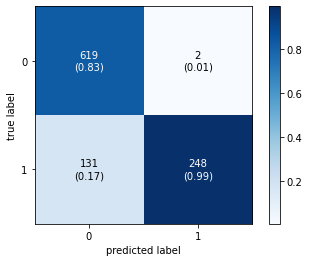

In [73]:
# 視覺化
binary = confusion_matrix(DATA_Pred2.case, DATA_Pred2.xgb_pred)
# class_names = ['normal', 'higher']
fig, ax = plot_confusion_matrix(conf_mat=binary,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
#                                 class_names=class_names
                               )
plt.show()

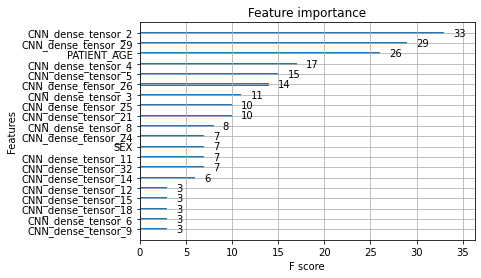

In [74]:
plot_importance(model_xgb, max_num_features=20, importance_type='weight')

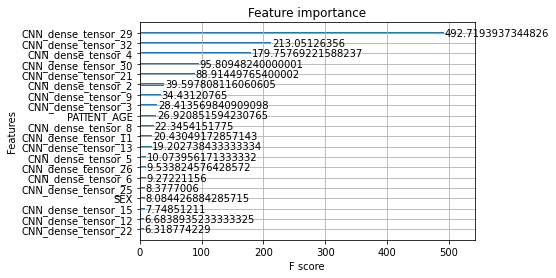

In [75]:
plot_importance(model_xgb, max_num_features=20, importance_type='gain')

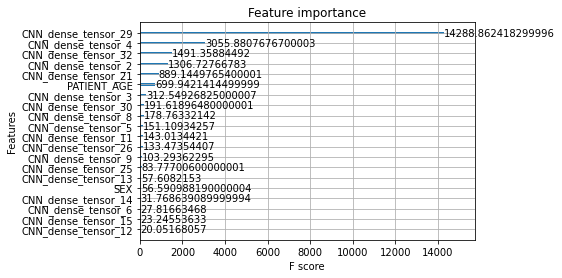

In [76]:
plot_importance(model_xgb, max_num_features=20, importance_type='total_gain')

In [77]:
explainer = shap.TreeExplainer(model=model_xgb)
shap_values = explainer.shap_values(X_test)
shap_values

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


array([[ 0.        , -0.35436413, -0.46542704, ..., -0.13004303,
         0.06233951,  0.38957816],
       [ 0.        ,  0.53188753,  0.03269557, ...,  0.61315924,
         0.11560238,  0.43887642],
       [ 0.        ,  0.47344336,  0.04157514, ...,  0.65041214,
        -0.15765229, -0.10381666],
       ...,
       [ 0.        , -1.2410287 , -0.46286273, ..., -0.13268887,
        -0.04073   ,  0.23514666],
       [ 0.        ,  0.15381046,  0.02808818, ..., -0.11124362,
        -0.08758794, -0.18953036],
       [ 0.        , -1.4003892 , -0.46583468, ..., -0.13653292,
         0.06233951, -0.1670748 ]], dtype=float32)

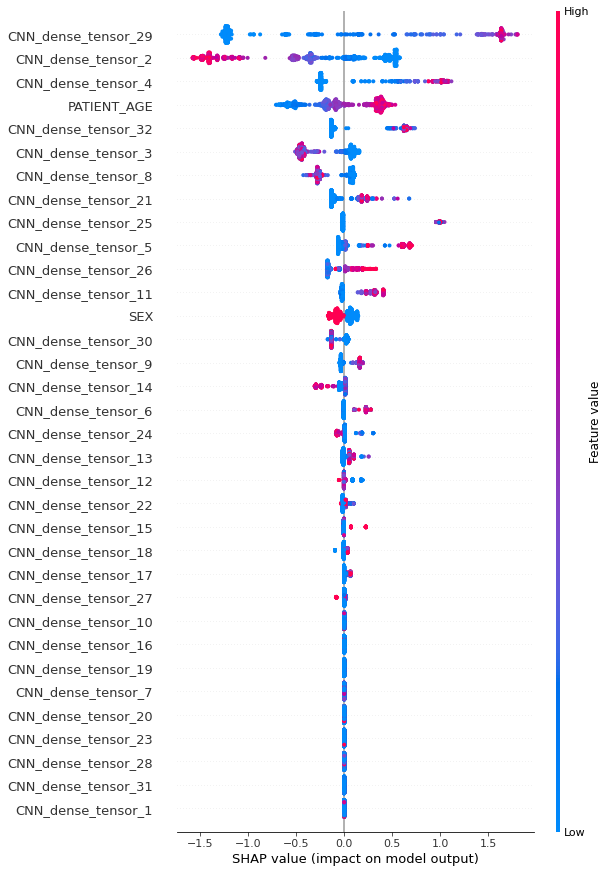

In [78]:
#shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, max_display = 50)

In [61]:
# q1 = explainer.shap_interaction_values(X_test)

In [49]:
# 取特徵
vals= np.abs(shap_values).mean(0)
shap_values_outcome = pd.DataFrame(list(zip(X_test.columns,vals)),columns=['feature_name', 'SHAP_vals'])
shap_values_outcome.sort_values(by=['SHAP_vals'],ascending=False,inplace=True)
shap_values_outcome

,feature_name,SHAP_vals
28,CNN_dense_tensor_29,1.147951
25,CNN_dense_tensor_26,0.414201
31,CNN_dense_tensor_32,0.411934
2,CNN_dense_tensor_3,0.364436
33,PATIENT_AGE,0.282872
1,CNN_dense_tensor_2,0.241091
5,CNN_dense_tensor_6,0.239625
3,CNN_dense_tensor_4,0.198396
10,CNN_dense_tensor_11,0.172950
12,CNN_dense_tensor_13,0.141114


In [45]:
#shap_values_outcome.to_csv('./shap_values_outcome_model3B_dense_0916.csv', index=False)

In [50]:
SH_keep = list(shap_values_outcome[shap_values_outcome['SHAP_vals']>0.01].feature_name.values)
SH_keep.append('KF')
SH_keep.append('case')
df_SH = df2[SH_keep]
df_SH

,CNN_dense_tensor_29,CNN_dense_tensor_26,CNN_dense_tensor_32,CNN_dense_tensor_3,PATIENT_AGE,CNN_dense_tensor_2,CNN_dense_tensor_6,CNN_dense_tensor_4,CNN_dense_tensor_11,CNN_dense_tensor_13,...,CNN_dense_tensor_14,CNN_dense_tensor_8,CNN_dense_tensor_20,CNN_dense_tensor_7,CNN_dense_tensor_25,CNN_dense_tensor_28,CNN_dense_tensor_27,CNN_dense_tensor_5,KF,case
0,0.000000,1.065909,0.000000,0.653862,81,0.736323,0.000000,0.000000,0.360082,0.000000,...,0.358629,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1
1,1.912771,1.203240,1.516706,0.000000,68,0.000000,0.720965,1.801040,1.914177,1.770721,...,0.000000,0.000000,0.607556,0.000000,0.678524,1.613941,1.223478,1.062028,4.0,1
2,1.200408,1.631537,0.471249,0.000000,80,0.055185,0.345658,0.416216,0.585071,0.402312,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.836147,2.0,1
3,0.968128,1.098351,0.138421,0.227261,73,0.000000,0.716640,0.605283,1.381076,1.205930,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.586811,0.549107,0.804863,1.0,1
4,0.695105,1.097424,0.015633,0.000000,77,0.223755,0.086099,0.298712,0.395569,0.647047,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.214114,1.010101,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6621,0.000000,1.031888,0.000000,0.597708,60,1.486525,0.000000,0.000000,0.000000,0.000000,...,1.049302,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0
6622,NaN,NaN,NaN,NaN,63,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6623,0.000000,0.000000,0.000000,1.892832,49,1.036284,0.000000,0.000000,0.000000,0.000000,...,0.603598,0.076396,0.000000,0.371515,0.000000,0.000000,0.000000,0.000000,4.0,0
6624,NaN,NaN,NaN,NaN,54,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [65]:
def quick_testing_xgb(inn, risk_cut= 0.75, n_esti=80, lr=0.1, md=2, save=0):
    st=time.time()
    test_GBK = inn['GKF'] == 1
    df_test = inn[test_GBK].drop('GKF', axis=1)
    df_train = inn[-test_GBK].drop('GKF', axis=1)
    X_train = df_train.drop('case', axis=1)
    X_test = df_test.drop('case', axis=1)
    y_train = df_train['case']
    y_test = df_test['case']
# modeling
    model_xgb = XGBClassifier(n_estimators=n_esti, learning_rate=lr, max_depth=md)

    model_xgb.fit(X_train, y_train)
    model_xgb_pred = model_xgb.predict(X_test)
    y_pred = model_xgb.predict_proba(X_test)[:, 1]
    # 模型成果
    print("Precision is {0:.2f}".format(precision_score(y_test, model_xgb_pred)))
    print("Recall is {0:.2f}".format(recall_score(y_test, model_xgb_pred)))
    print("Accuracy is {0:.2f}".format(accuracy_score(y_test, model_xgb_pred)))
    print("F1 is {0:.2f}".format(f1_score(y_test, model_xgb_pred)))
    print("ROC_AUC is {0:.3f}".format(roc_auc_score(y_test, y_pred)))
    
    DATA_Pred = pd.DataFrame(y_pred)
    threshold = DATA_Pred.quantile(risk_cut)
    
    DATA_Pred.columns = ['xgb_proba']
    y_test_removeindex = pd.DataFrame(y_test).reset_index(drop=True)
    DATA_Pred2 = pd.concat([DATA_Pred.xgb_proba, y_test_removeindex.case], axis=1)
    DATA_Pred2['XGB_p'] = np.where(DATA_Pred['xgb_proba'] >= threshold[0], 1, 0)
    DATA_Pred2.columns = ['xgb_proba', 'case', 'xgb_pred']

    binary = confusion_matrix(DATA_Pred2.case, DATA_Pred2.xgb_pred)
    # class_names = ['normal', 'higher']
    fig, ax = plot_confusion_matrix(conf_mat=binary,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
    #                                 class_names=class_names
                               )
    plt.show()
    
    #SHAPE
    explainer = shap.TreeExplainer(model=model_xgb)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, max_display = 40)
    
    #save model
    if save==1:
        joblib.dump(model_xgb, 'short_model_1')
        print('dump to joblib')
    
    print(f'耗時 {round(time.time()-st,1)} sec')

In [ ]:
quick_testing_xgb(df_SH)

In [ ]:
#### dump to joblib

In [ ]:
# 調參
estimator = XGBClassifier(
    objective='binary:logistic',
    nthread=4,
    seed=69
)

In [ ]:
parameters = {
    'max_depth': range (2, 10, 1),
     #'n_estimators': range(60, 160, 20),
     'n_estimators': [80, 120],
     'learning_rate': [0.1, 0.08]
}

In [ ]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 5,
    cv = 5,
    verbose=True
)

In [ ]:
grid_search.fit(X_train,y_train)

In [ ]:
grid_search.best_estimator_

In [ ]:
# grid_search 模型成果
GS_pred = grid_search.predict(X_test)
GS_y_pred = grid_search.predict_proba(X_test)[:, 1]

print("Precision is {0:.2f}".format(precision_score(y_test, GS_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, GS_pred)))
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, GS_pred)))
print("F1 is {0:.2f}".format(f1_score(y_test, GS_pred)))
print("ROC_AUC is {0:.3f}".format(roc_auc_score(y_test, GS_y_pred)))